#  Solution Planning

## Business Problem

**What is the business problem?**
1. Select the most valuable customers to join the "Loyals" loyalty program.

2. Answering business questions to the marketing team.

### Output

**What will I deliver? / Where does the business team want to see it?**

* 1) List in xls / send by email. It must contain customers who will join Loyals (loyalty program).
    - Format:
   
| client_id | is_loyal |
|-----------|----------|
|1          |yes       |
|2          |no        |

* 2) PDF report answering business questions / send by email and present to the marketing team:
     - Who are the people eligible to participate in the Loyals program?
     - How many customers will be part of the group?
     - What are the main characteristics of these customers?
     - What is the percentage of revenue contribution from Loyals?
     - What is the expected revenue for this group for the coming months?
     - What are the conditions for a person to be eligible for Loyals?
     - What are the conditions for a person to be removed from Loyals?
     - What is the guarantee that the Loyals program is better than the rest of the base?
     - What actions can the marketing team take to increase revenue?

### Input

**Data sources:**
     Dataset "Ecommerce.csv", containing e-commerce sales for the period of one year.

**Tools:**
     Python 3.8.13, Jupyter Notebook, Git, Github.

### Tasks

**Type of problem:**
Separation of customers by groups.
    
**Main methods:**
    clustering.

**Business Questions:**
* 1) Who are the people eligible to participate in the Loyals program?
    - What does it mean to be eligible? / What are higher "value" customers? (depending on business area)
        - Invoicing:
             - High average ticket
             - High LTV (sum of customer revenue)
             - Low recency (time since last purchase)
             - High basket size (qty products purchased per purchase)
             - Low churn probability (would use the output of a model)
             - High LTV Prediction (would use output from a model)
             - High propensity to buy (would use the output of a model)
        - Cost:
             - Low return rate
        - Shopping experience:
             - High average of the evaluations
 
 
* 2) How many customers will be part of the group?
    - Number of customers
    - % in relation to the total number of clients
    
    
* 3) What are the main characteristics of these customers?
    - Write customer characteristics:
        - Age
        - Country
        - Wage
        - Location
     - Write key customer buying behaviors (business metrics)
        - See clustering features (question 1)
         
 For look alike: prospecting similar customers on the internet


* 4) What percentage of revenue contribution comes from Loyals?
    - Calculate the company's total revenue during the year.
    - Calculate the revenue (%) for the Loyals cluster only.
   
   
* 5) What is the expected revenue for this group for the coming months?
    - Loyals LTV calculation (with moving average, time series, arima..)
    - Time Series (ARMA, ARIMA, HoltWinter, etc.)
    - Cohort analysis (with time, location, product..)

 There must be a billing target, consult business.
    
    
* 6) What are the conditions for a person to be eligible for Loyals?
    - Set the evaluation interval (every 1 month, 3 months..)
    - The client's "performance" should be close to the Loyals cluster average.
    
    
* 7) What are the conditions for a person to be removed from Loyals?
    - Customer "performance" is no longer closer to the Loyals cluster average.
   
   
* 8) What is the guarantee that the Loyals program is better than the rest of the base?
    - A/B test
    - Hypothesis test


* 9) What actions can the marketing team take to increase revenue?
    - Discount
    - Purchase preference
    - Cheaper shipping
    - Visit the company
    - Offer personal stylist
    - Recommend cross selling
    - Offer exclusive content

### Solution Benchmarking

#### Desk Research

Reading articles on customer segmentation on the internet to understand what the market is doing.

Identify from market solutions, with the business team, what we can do as an MVP.

1. RFM segmentation model.

## <font color='black'> Cycle 01 - Metrics to validate clusters </font>

1. Feature Engineering
    - Recency
    - Quantity of purchases
    - Monetary
    
    
2. Metrics to validate clusters
    - WSS (Within-Cluster Sum of Square)
    - SS (Silhouette Score)


3. Cluster Analysis
    - Plot 3D
    - Cluster Profile

## <font color='black'> Cycle 02 - Silhouette Analysis </font>

1. Feature Engineering
    - Average ticket
    
    
2. Silhouette Analysis


3. Cluster Visualization (reduce the cluster dimensions)
    - UMAP    


4. Cluster Profile Analysis
    - Description of cluster centroids

## <font color='black'> Cycle 03 - Descriptive Statistics </font>

1. Descriptive Analysis
    - Numerical Attributes
    - Categorical Attributes
    
    
2. Variable Filtering
    - unit price > 0.04
    - stock code != full characters
    - quantity - split into purchase (positive values) and return (negative values)
    - country - delete unspecified countrys and European Community (because of lat and long)
    - description - delete column 
    
    
3. Feature Engineering
    - Adapt features to positive quantity (purchase)
        

4. Data preparation
    - Standard Scaler


## <font color='black'> Cycle 04 - Feature Engineering </font>

1. Data description
    - recover the 25% of customer_id NA (assumption: create a dummy customer id for each invoice number)
    
    
2. Feature Engineering
    - Quantity of items purchased
    - Quantity of products purchased
    - Frequency purchase
    - Number of returns
    

## <font color='red'> Cycle 05 - EDA </font>

1. EDA
    - Univariate Analysis
    - Bivariate Analysis
    - Space Study


#  0.0 Imports 

In [1]:
import pandas   as pd
import numpy    as np
import seaborn  as sns
import inflection

from matplotlib           import pyplot   as plt
from plotly               import express  as px
from IPython.display      import Image
from IPython.core.display import HTML
from tabulate             import tabulate
from yellowbrick.cluster  import KElbowVisualizer, SilhouetteVisualizer
import umap.umap_ as umap
import re

from pandas_profiling     import ProfileReport 
from sklearn              import cluster       as c
from sklearn              import metrics       as m
from sklearn              import preprocessing as pp
from sklearn              import decomposition as dd
from sklearn.manifold     import TSNE
from sklearn              import ensemble      as en

import warnings

C:\Users\SBG\anaconda3\envs\clustering\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
       
    plt.style.use('bmh')
    plt.rcParams ['figure.figsize'] = [22,12]
    plt.rcParams ['font.size'] = 12
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
       
    warnings.filterwarnings("ignore")
    
jupyter_settings()

# 0.2 Load dataset

In [3]:
# read data
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='unicode_escape')

In [4]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN


In [5]:
df_raw = df_raw.drop('Unnamed: 8', axis=1).copy()
df_raw.sample(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
152564,C549666,21470,FLOWER VINE RAFFIA FOOD COVER,-1,9-Apr-17,3.75,13113.0,United Kingdom
512880,579520,22840,ROUND CAKE TIN VINTAGE RED,1,27-Nov-17,7.95,12748.0,United Kingdom


# 1.0 Data description 

In [6]:
df1 = df_raw.copy()

## <font color='black'> 1.1 Rename columns </font>

In [7]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [8]:
# columns names
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerId', 'Country']

# transforming to underscore the names and put into lowcase
snakecase = lambda x: inflection.underscore( x )

# creating a list with a new snakecase columns name and indicating the new one
cols_new = list( map( snakecase, cols_old ) )

# renaming columns name
df1.columns = cols_new

### <font color='black'>  Feature Description </font>

In [9]:
# Feature meanings
tab_meanings = [['Columns', 'Meaning'],
        ['invoice_no', 'unique identifier of each transaction'],
        ['stock_code', 'item code'],
        ['description', 'item name'],
        ['quantity', 'quantity of each item purchased per transaction'],
        ['invoice_date', 'the day the transaction took place'],
        ['unit_price', 'product price per unit'],
        ['customer_id', 'unique customer identifier'],
        ['country', 'customer\'s country of residence']
      ]
print(tabulate(tab_meanings, headers='firstrow', stralign='left', tablefmt='simple'))

Columns       Meaning
------------  -----------------------------------------------
invoice_no    unique identifier of each transaction
stock_code    item code
description   item name
quantity      quantity of each item purchased per transaction
invoice_date  the day the transaction took place
unit_price    product price per unit
customer_id   unique customer identifier
country       customer's country of residence


## <font color='black'> 1.2 Data dimensions </font>

In [10]:
print('Number of rows {}'.format(df1.shape[0]))
print('Number of columns {}'.format(df1.shape[1]))

Number of rows 541909
Number of columns 8


## <font color='black'> 1.3 Data types </font>

In [11]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## <font color='black'> 1.4 Check NA </font>

In [12]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## <font color='black'> 1.5 Replace NA </font>

In [13]:
df_missing = df1.loc[df1['customer_id'].isna(),:]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]


In [14]:
# check if we can fill customer NA by invoice correspondence
#missing_invoice = df_missing['invoice_no'].drop_duplicates().tolist()

#df_not_missing.loc[df_not_missing['invoice_no'].isin(missing_invoice), :]

In [15]:
# create a dummy customer id for each invoice number 
# create reference dataframe
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup),1)

# merge original with reference dataframe
df1 = pd.merge(df1, df_backup, on='invoice_no' , how='left' )

# coalesce
df1 ['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1 = df1.drop(columns=['customer_id_x','customer_id_y'], axis=1)

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,United Kingdom,17850.0


In [16]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## <font color='black'> 1.6 Change types </font>

In [17]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

In [18]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,United Kingdom,17850.0


In [19]:
# invoice date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

In [20]:
# customer id
df1['customer_id'] = df1['customer_id'].astype(np.int64)

In [21]:
# invoice_no
#df1['invoice_no'] = df1['invoice_no'].astype(int)
#there are letters on invoice, so let it like object(string). Ex: 'C536379', 'C554197'

In [22]:
# stock_code
#df1['stock_code'] = df1['stock_code'].astype(int)
#there are letters on stock_code, so let it like object(string). Ex: '85123A', '84406B'

In [23]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


## <font color='black'> 1.7 Descriptive statistics  </font>

In [24]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64'])


### <font color='black'> 1.7.1 Numerical Attributes  </font>

In [25]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() -x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


#### <font color='black'> 1.7.1.1 Numerical Attributes - Investigating  </font>

1. Negative quantity 
2. Price equal to zero

### <font color='black'> 1.7.2 Categorical Attributes  </font>

#### Invoice No

In [26]:
# The invoice_no has characters and numbers
#df1['invoice_no'].astype(int)

# identifying 
df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+',x))),:]
df_letter_invoices.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
141,C536379,D,Discount,-1,2016-11-29,27.50,United Kingdom,14527
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2016-11-29,4.65,United Kingdom,15311
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2016-11-29,1.65,United Kingdom,17548
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2016-11-29,0.29,United Kingdom,17548
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2016-11-29,0.29,United Kingdom,17548


In [27]:
# number of invoices that have at least a character in the invoice number and quantity are negative
print('Total number of invoices: {}'.format(len(df_letter_invoices)))
print('Total number of negative quantity: {}'.format(len(df_letter_invoices[df_letter_invoices['quantity'] < 0])))

Total number of invoices: 9291
Total number of negative quantity: 9288


#### <font color='black'> Stock Code </font>

In [28]:
# check stock codes - only characters
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$',x))),'stock_code'].unique()


array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

In [29]:
# Actions:
# Remove stock_code in [POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']

#### Descriptions

In [30]:
df1.head()

# Action: Delete description

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


#### Country

In [31]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [32]:
df1['country'].value_counts(normalize=True).head()

United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: country, dtype: float64

In [33]:
df1[['customer_id','country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False).head()

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# <font color='black'> 2.0 Variables Filtering </font>

In [34]:
df2 = df1.copy()

In [35]:
# unit price > 0.0
df2 = df2.loc[df2['unit_price'] >=0.04,:]

# stock code != ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# description
df2 = df2.drop(columns = 'description', axis=1)

# quantity - Negative numbers means product returns
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchase = df2.loc[df2['quantity'] > 0, :]



# <font color='black'> 3.0 Feature Engineering </font>

In [43]:
df3 = df2.copy()

## <font color='black'> 3.1 Feature creation  </font>

In [44]:
# data reference
df_ref = df3.drop(['invoice_no','stock_code','quantity','invoice_date','unit_price','country'],axis=1).drop_duplicates(ignore_index=True)


### <font color='black'> 3.1.1 Gross Revenue  </font>

In [45]:
# Gross Revenue
df2_purchase['gross_revenue'] = df2_purchase['quantity'] * df2_purchase['unit_price']

# Monetary
df_monetary = df2_purchase[['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, how='left', on='customer_id')


### <font color='black'> 3.1.2 Recency - Day from last purchase  </font>

In [46]:
# Recency - it depende on product returns
df_recency = df2_purchase[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2_purchase['invoice_date'].max()-df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id','recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

### <font color='black'> 3.1.3 Quantity of purchases </font>

In [47]:
# Number of purchases
df_freq=df2_purchase[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no':'qtde_invoices'})
df_ref = pd.merge(df_ref,df_freq, on='customer_id',how='left')

### <font color='black'> 3.1.4 Quantity of items purchased </font>

In [48]:
# Number of products
df_freq=df2_purchase[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qtde_items'})
df_ref = pd.merge(df_ref,df_freq, on='customer_id',how='left')

### <font color='black'> 3.1.5 Quantity of products purchased </font>

In [49]:
# Number of products
df_freq=df2_purchase[['customer_id', 'stock_code']].groupby('customer_id').count().reset_index().rename(columns={'stock_code':'qtde_products'})
df_ref = pd.merge(df_ref,df_freq, on='customer_id',how='left')

### <font color='black'> 3.1.6 Average Ticket Value  </font>

In [50]:
# Avg Ticket
df_avg_ticket = df2_purchase[['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')


### <font color='black'> 3.1.8 Frequency Purchase </font>

In [51]:
df_aux = (df2_purchase[['customer_id','invoice_no','invoice_date']].drop_duplicates()
                                                 .groupby('customer_id')
                                                 .agg(max_=('invoice_date', 'max'), 
                                                      min_=('invoice_date', 'min'), 
                                                      days_=('invoice_date',lambda x: (x.max()-x.min()).days +1),
                                                      buy_=('invoice_no', 'count'))).reset_index()

# frequency
df_aux['frequency'] = df_aux[['buy_','days_']].apply(lambda x: x['buy_']/x['days_'] if x['days_'] != 0 else 0, axis=1)

# Merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
avg_ticket       91
frequency        91
dtype: int64

### <font color='black'> 3.1.9 Number of Returns </font>

In [52]:
# Number of returns
df_returns = df2_returns[['customer_id','quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qtde_returns'})
df_returns['qtde_returns'] = df_returns['qtde_returns']*(-1)

df_ref = pd.merge(df_ref, df_returns, on='customer_id', how='left')
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns']=0
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
avg_ticket       91
frequency        91
qtde_returns      0
dtype: int64

In [53]:
df_ref.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,frequency,qtde_returns
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,17.000000,40.0
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,0.028302,35.0
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,0.040323,50.0
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,0.017921,0.0
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,0.073171,22.0


# <font color='red'> 4.0 Exploratory Data Analysis </font>

In [54]:
df4 = df_ref.dropna().copy()

## <font color='red'> 4.1 Univariate Analysis </font>

1. Compact and separate clusters
2. Metrics
    - Min, Max, Range (dispersion)
    - Mean and Median
    - Std and Variance
    - Coefficient of variation (CV = std/mean)
    - Distribution

In [55]:
profile = ProfileReport(df4)
profile.to_file('../reports/univariate_analysis_V01.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 19.65it/s]


### <font color='red'> 4.1.1 Gross Revenue </font>

In [56]:
df4.sort_values('gross_revenue', ascending=False).head(3)

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,frequency,qtde_returns
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,0.203390,288.0
492,18102,259657.30,0.0,60.0,64124.0,431.0,602.453132,0.163043,0.0
433,17450,194550.79,8.0,46.0,69993.0,337.0,577.302047,0.127778,952.0


### <font color='red'> 4.1.2 Qtde Items </font>

In [57]:
df4.sort_values('qtde_items', ascending=False).head(3)

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,frequency,qtde_returns
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,0.203390,288.0
3341,16446,168472.50,0.0,2.0,80997.0,3.0,56157.500000,0.009709,80995.0
66,14911,140450.72,1.0,199.0,80263.0,5673.0,24.757751,0.533512,3332.0


### <font color='red'> 4.1.3 Avg Ticket </font>

In [58]:
df4.sort_values('avg_ticket', ascending=False).head(3)

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,frequency,qtde_returns
1381,12346,77183.6,325.0,1.0,74215.0,1.0,77183.6,1.000000,74215.0
3341,16446,168472.5,0.0,2.0,80997.0,3.0,56157.5,0.009709,80995.0
3635,15098,39916.5,182.0,3.0,121.0,3.0,13305.5,3.000000,60.0


In [59]:
df3[df3['customer_id']==16446]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
194354,553573,22980,1,2017-05-16,1.65,United Kingdom,16446
194355,553573,22982,1,2017-05-16,1.25,United Kingdom,16446
540421,581483,23843,80995,2017-12-07,2.08,United Kingdom,16446
540422,C581484,23843,-80995,2017-12-07,2.08,United Kingdom,16446


## <font color='red'> 4.2 Bivariate Analysis </font>

In [60]:
df42=df4.drop('customer_id', axis=1)

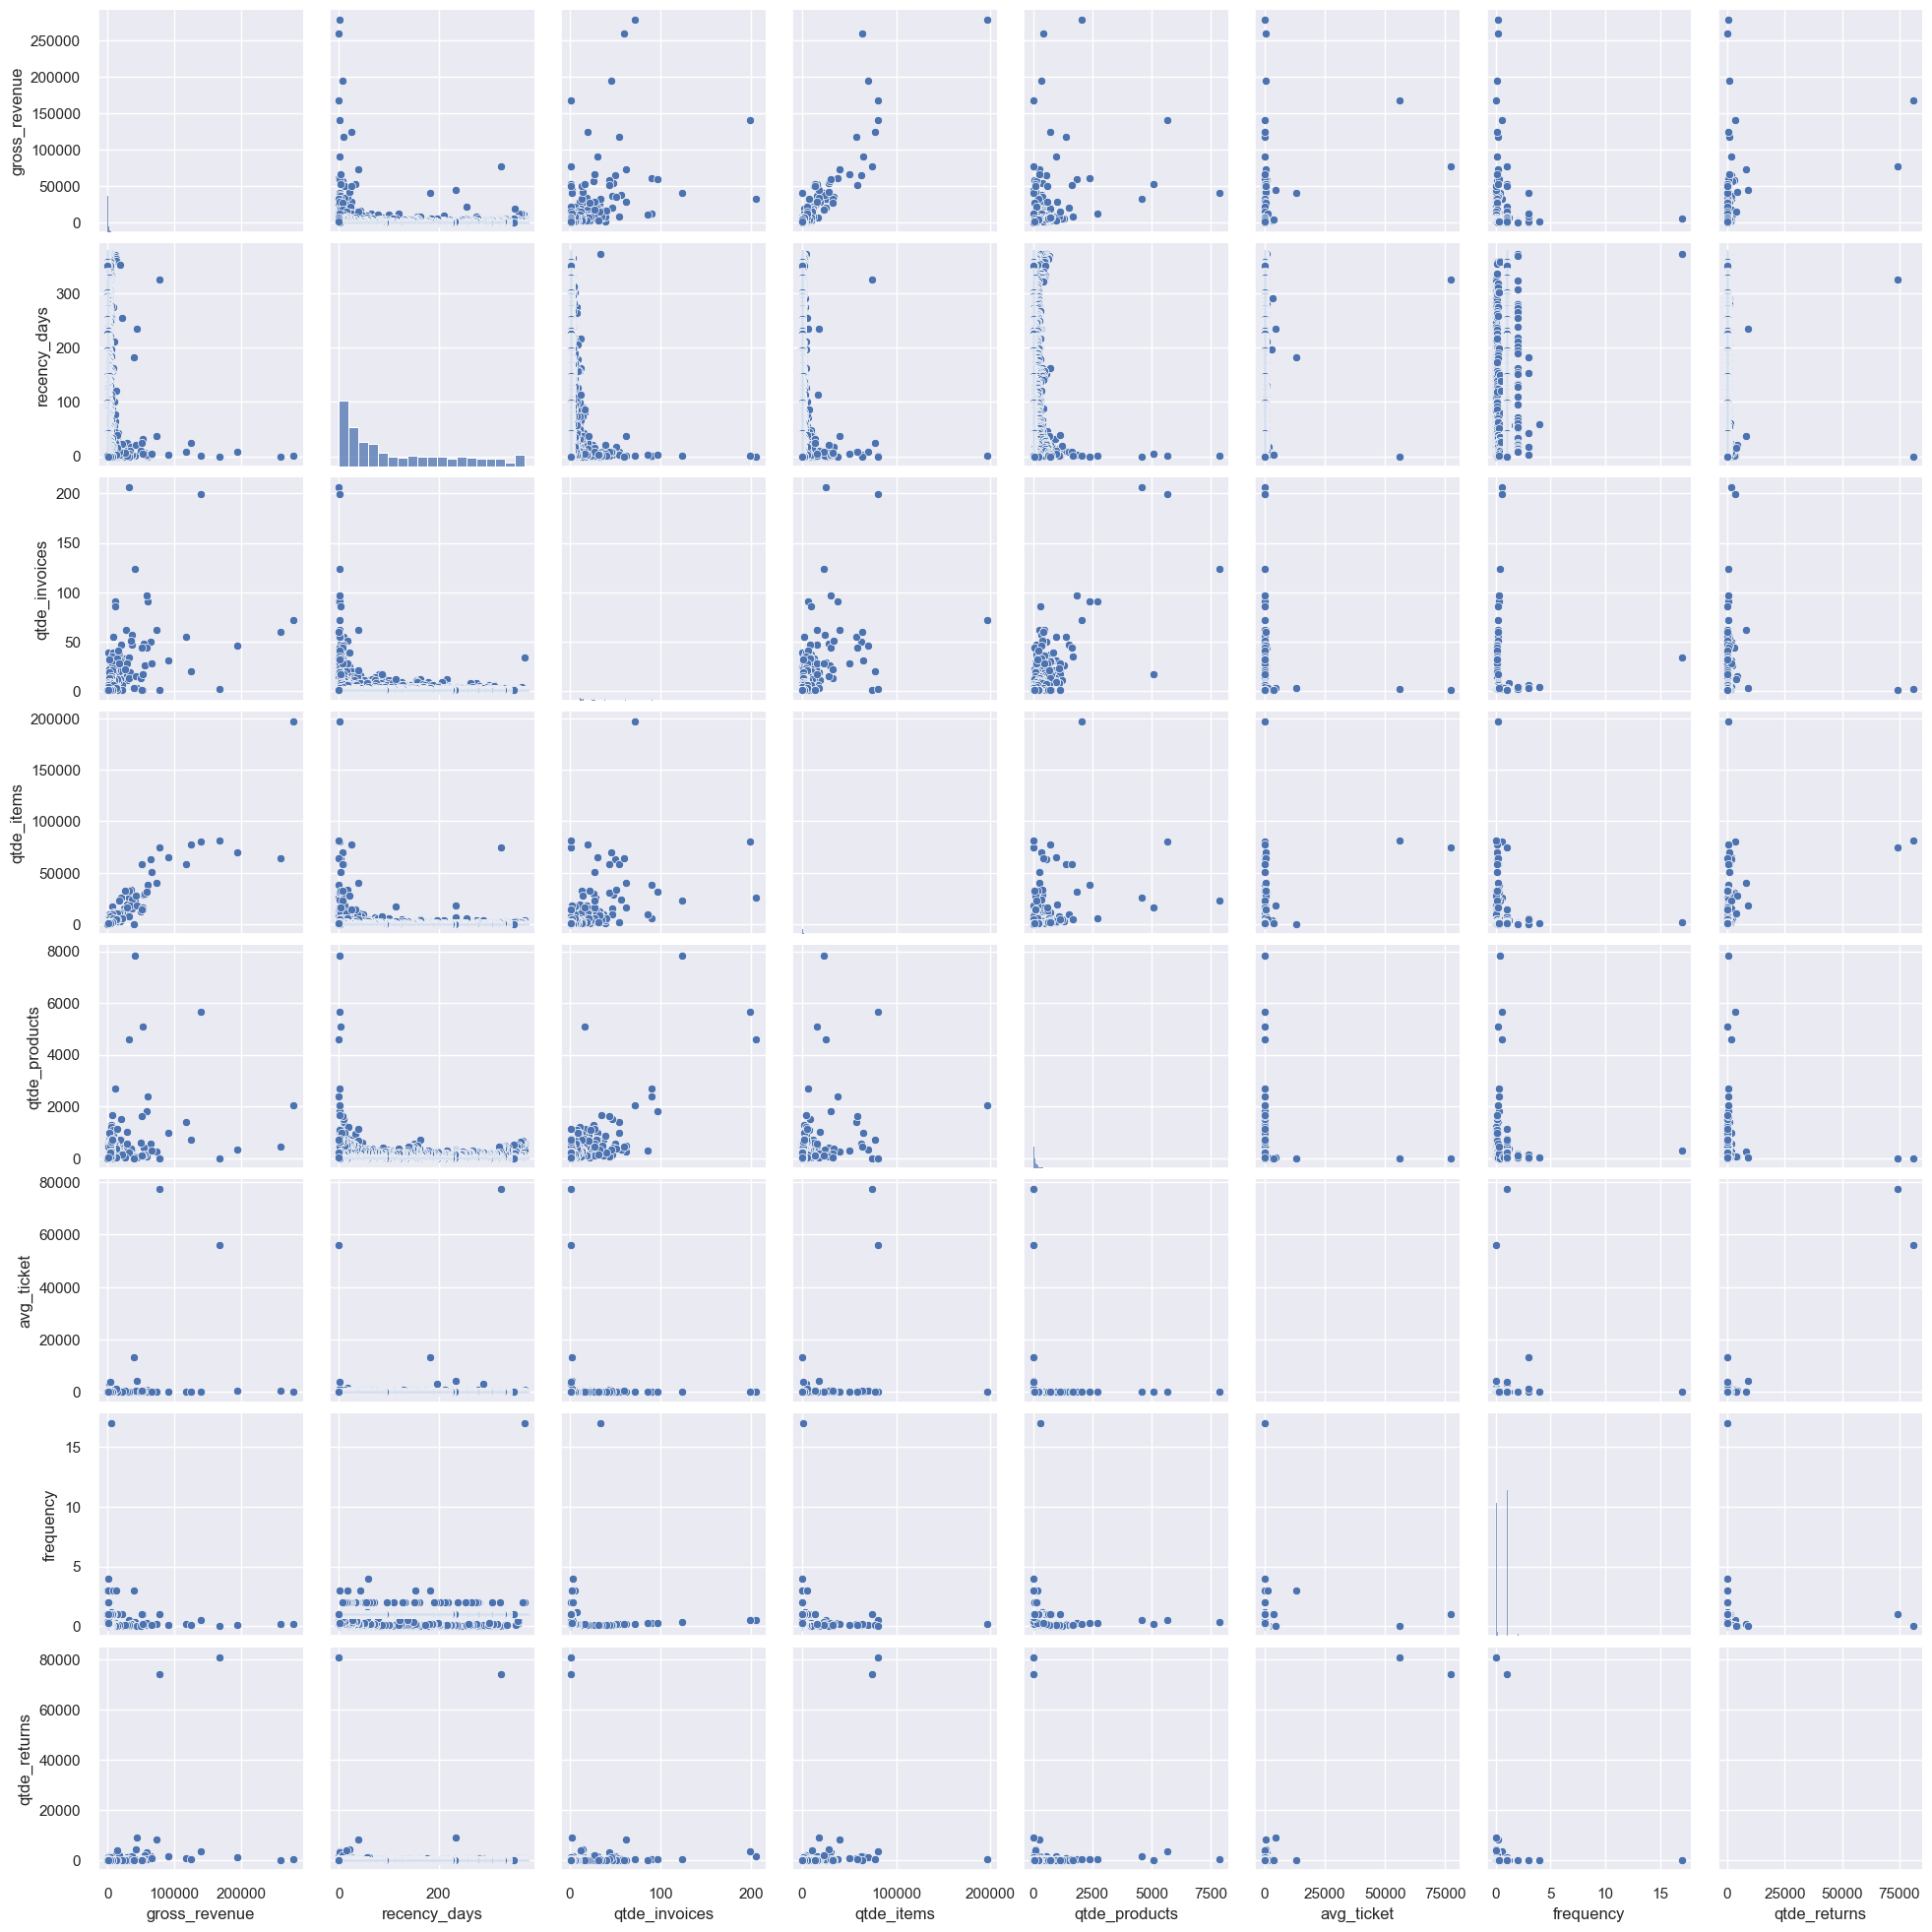

In [70]:
sns.pairplot(df42);

## <font color='red'> 4.3 Space Study </font>

In [61]:
df43=df4.drop('customer_id', axis=1)

In [62]:
mm = pp.MinMaxScaler()

df43['gross_revenue']          = mm.fit_transform( df43[['gross_revenue']])
df43['recency_days']           = mm.fit_transform( df43[['recency_days']])
df43['qtde_invoices']          = mm.fit_transform( df43[['qtde_invoices']])
df43['qtde_items']             = mm.fit_transform( df43[['qtde_items']])
df43['qtde_products']          = mm.fit_transform( df43[['qtde_products']])
df43['avg_ticket']             = mm.fit_transform( df43[['avg_ticket']])
df43['frequency']              = mm.fit_transform( df43[['frequency']])
df43['qtde_returns']           = mm.fit_transform( df43[['qtde_returns']])

X = df43.copy()


### <font color='red'> 4.3.1 PCA </font>

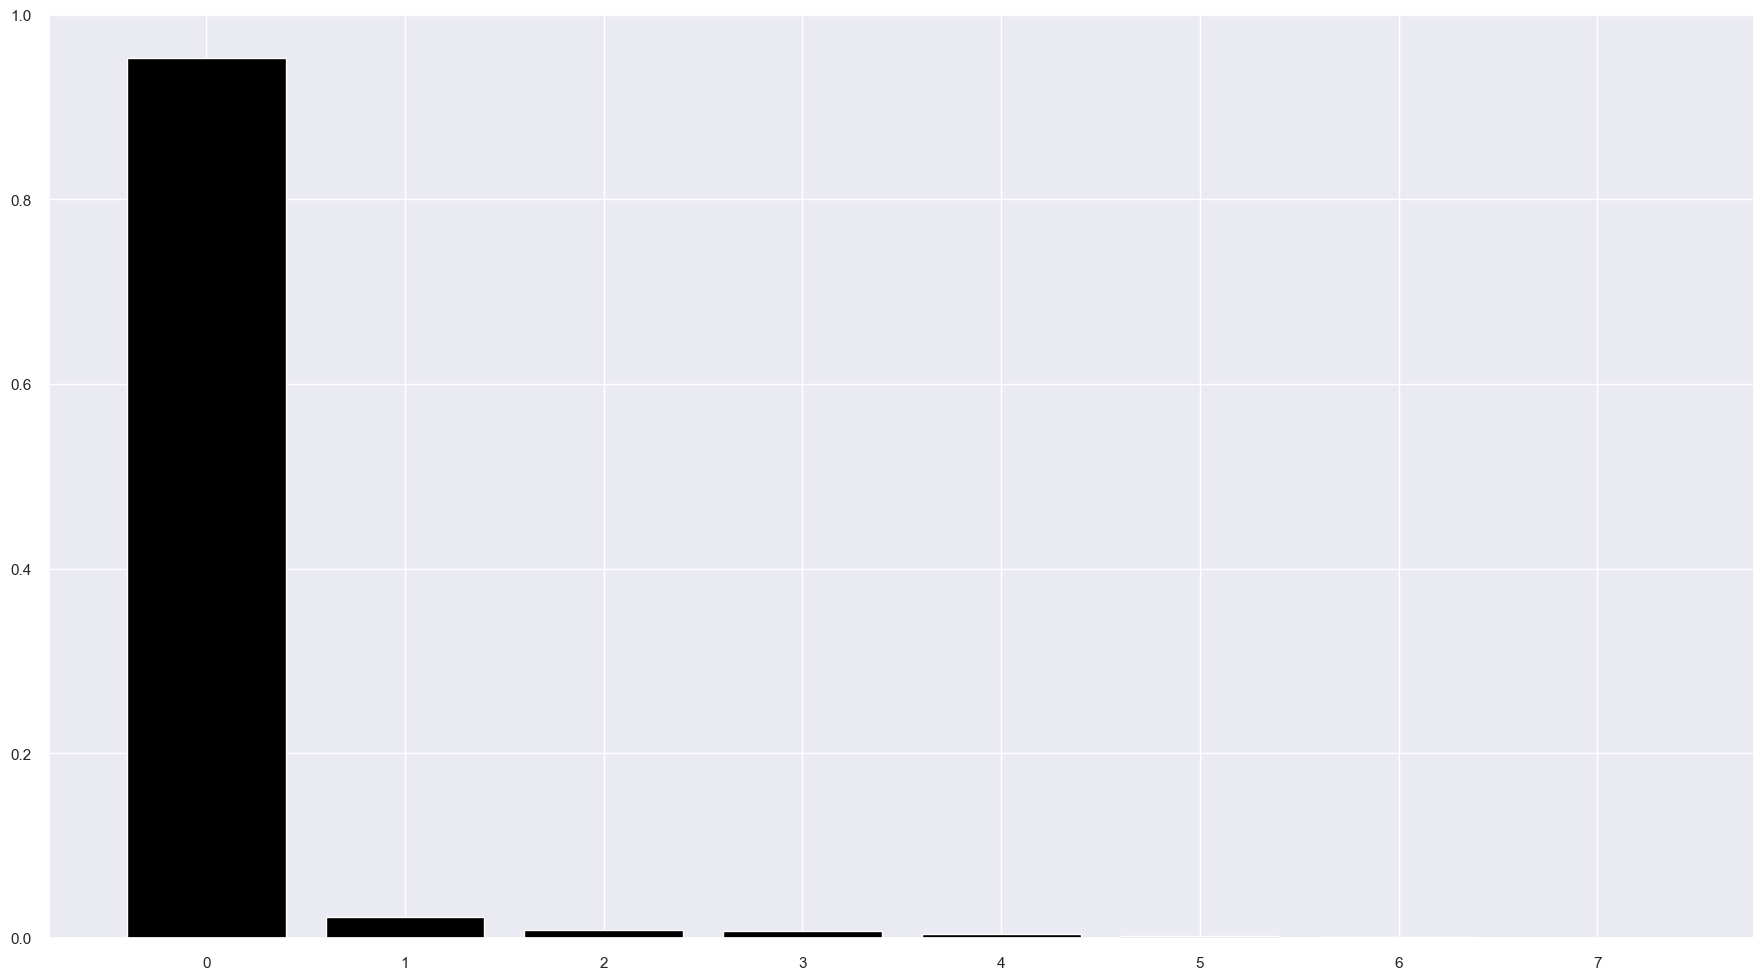

In [63]:
pca = dd.PCA( n_components=X.shape[1] )

principal_components = pca.fit_transform( X )

# plot explained variable
features = range( pca.n_components_)

plt.bar( features, pca.explained_variance_ratio_, color= 'black');

# pca component
df_pca = pd.DataFrame( principal_components )


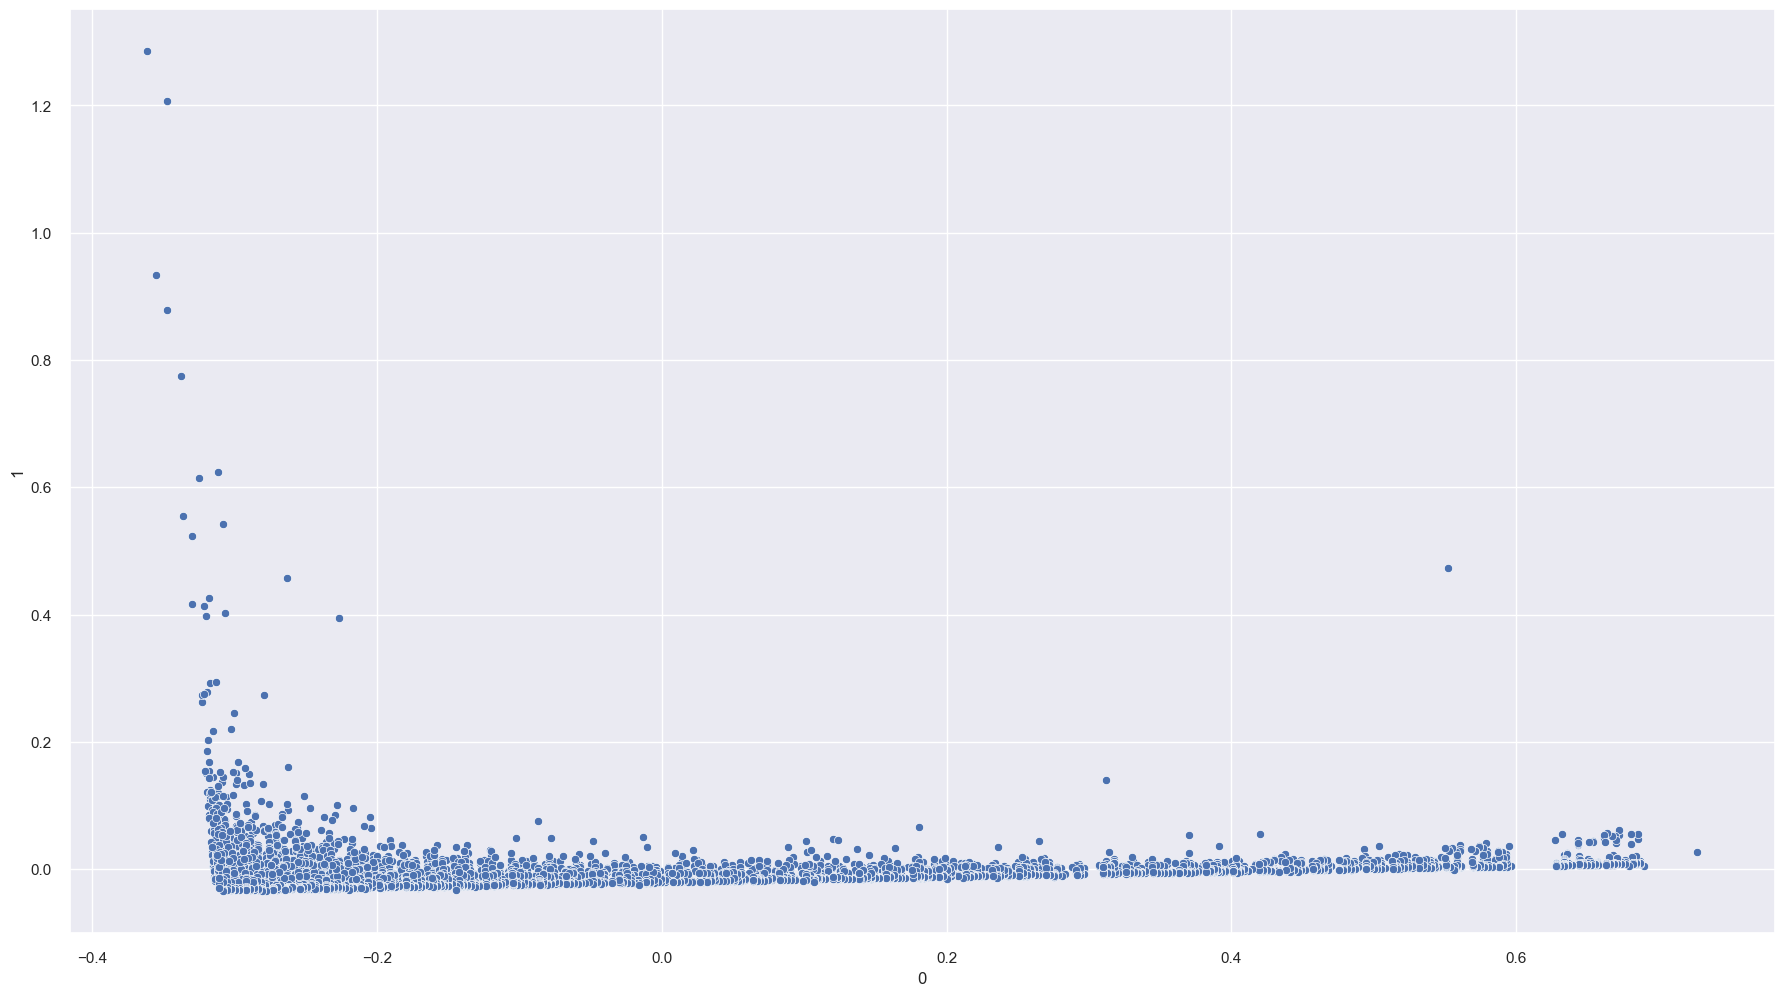

In [64]:
sns.scatterplot( x=0, y=1, data=df_pca);

### <font color='red'> 4.3.2 UMPA </font>

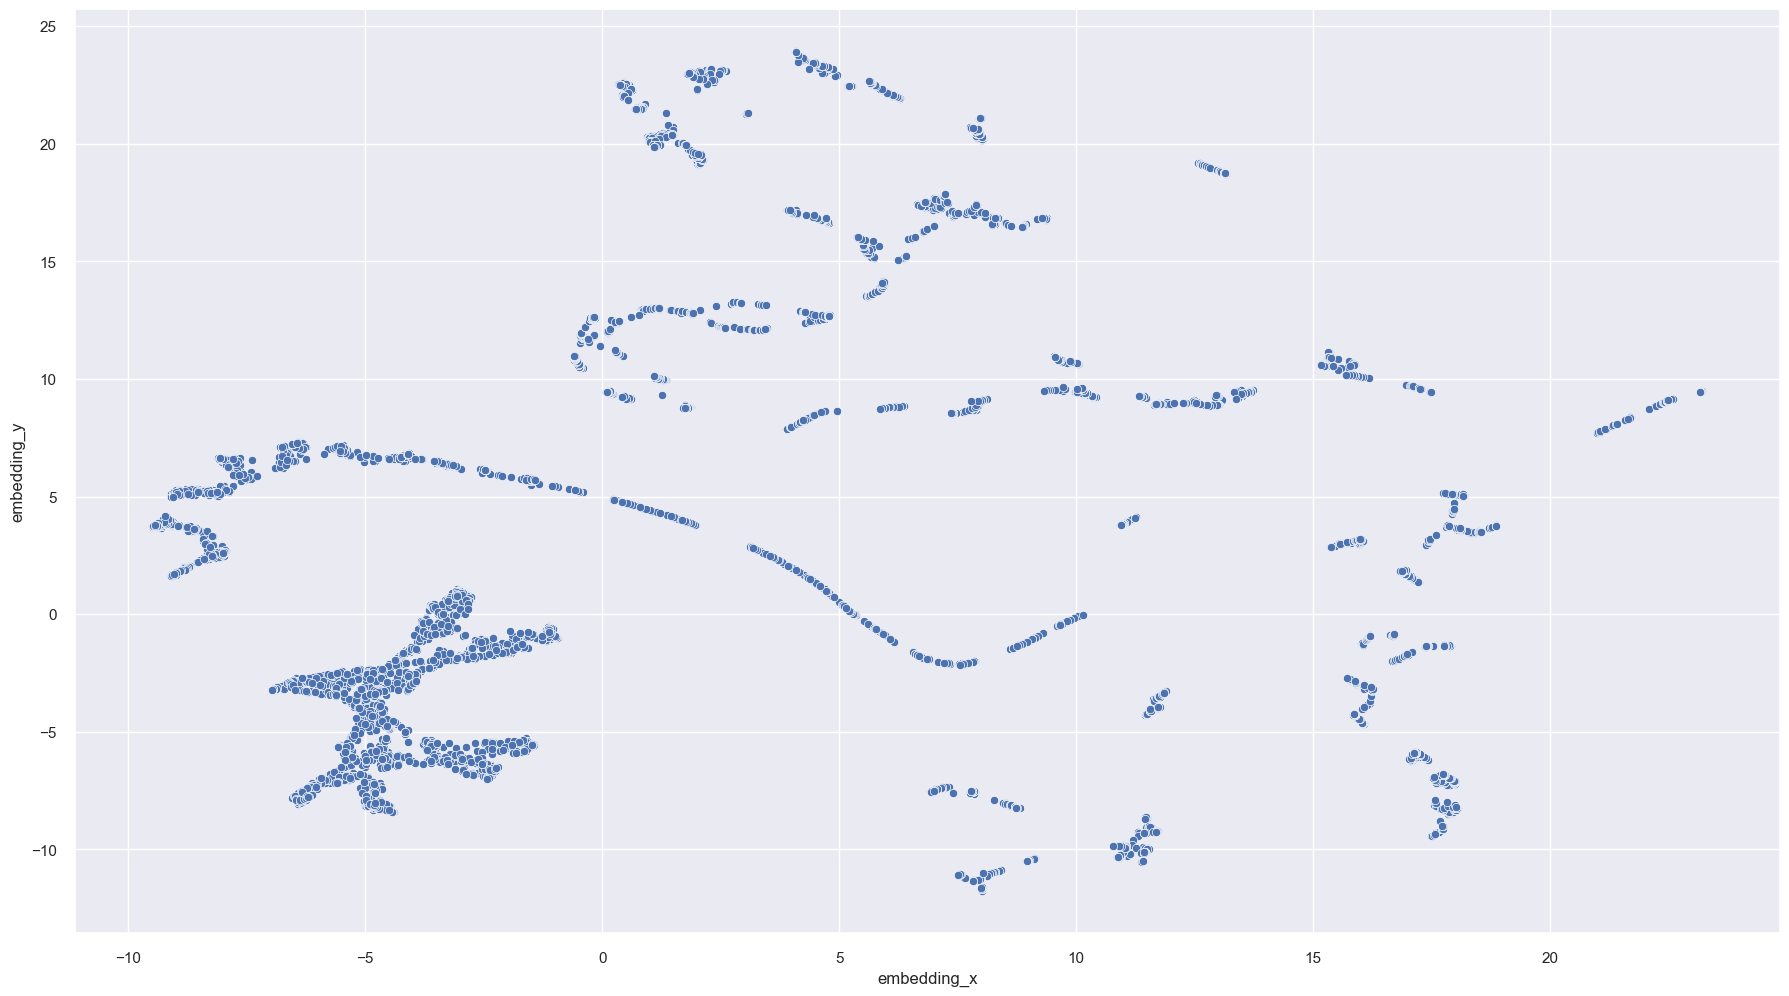

In [65]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y',
                data=df_pca);

### <font color='red'> 4.3.3 t-SNE </font>

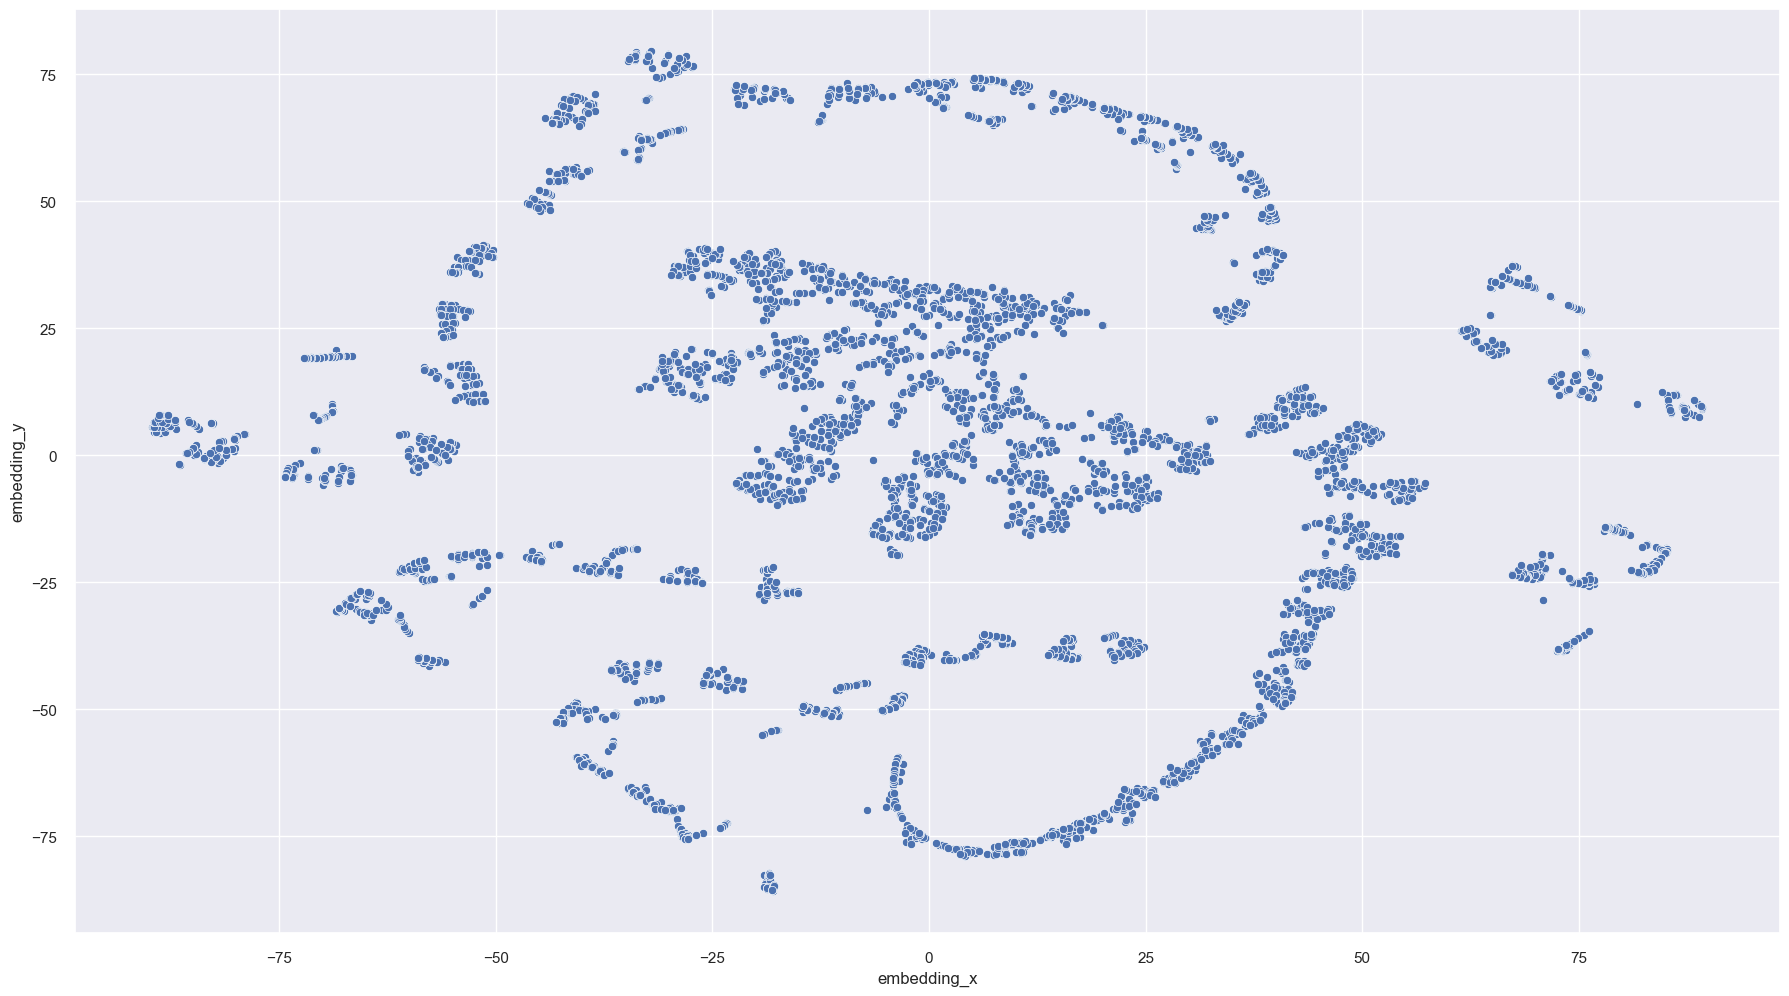

In [66]:
reducer = TSNE(n_components=2, n_jobs=1, random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y',
                data=df_pca);

### <font color='red'> 4.3.4 Tree-Based Embedding </font>

In [67]:
# training dataset
X = df4.drop(columns=['customer_id','gross_revenue'], axis=1)
y = df4['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42)

# model training
rf_model.fit( X,y )

# leaf
df_leaf = rf_model.apply( X )

# dataframe leaf
df_leaf = pd.DataFrame( df_leaf )


In [68]:
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,5961,6576,6913,6440,6468,6418,6549,6367,6476,6634,6478,6766,6321,6455,6483,6375,6336,6321,6418,6342,6508,6350,6392,6514,6379,6460,6409,6457,6346,6718,6729,6699,6261,6432,6260,6598,6657,6520,6452,6350,6580,6503,6157,6467,6727,6233,6551,6669,6346,6534,6497,6385,6600,6491,6747,6409,6347,6566,6441,6383,6378,6946,6306,6666,6261,5866,6616,6329,6338,6457,6562,6355,6515,6307,6433,6402,6304,6635,6367,6489,6697,6479,6480,6508,6479,6637,6401,6402,6494,6514,6457,6475,6561,6351,6384,6470,6376,6413,6353,6625
1,6250,6272,6179,6310,6420,6379,6401,6351,6426,6482,6389,6222,6225,6395,6349,6276,6297,5958,6321,6296,6480,6194,6316,6206,6333,6307,6372,6250,6230,6144,6240,6405,6331,6357,6154,6319,6450,6387,6319,6316,6340,6168,6053,6309,6336,6215,6339,6134,6223,6164,6422,6377,6497,6177,6134,6383,6273,6067,6065,6335,6308,6133,6208,6195,6284,6224,6581,6275,6290,6444,6064,6143,6142,6197,6286,6138,6204,6325,6332,6195,6612,5988,6112,6437,6407,5871,6121,6340,6366,6408,6253,6204,6509,5827,6258,6052,6110,6345,6331,6504
2,6877,7054,6955,6973,6835,7033,6965,6928,6850,7042,7027,6878,6877,6949,6915,6852,6761,6890,6944,6873,6981,6889,6955,6828,6905,6961,6882,6990,6792,6963,7028,7180,6951,6937,6986,7100,6990,6988,6800,6918,6912,6800,6970,6971,7001,6930,6999,6813,6959,6974,7018,6866,6954,6902,6985,6899,6877,6848,6909,6935,7014,6827,6989,6938,6979,6964,6945,6876,6906,6965,6894,6961,6852,6894,6753,6999,6803,6910,7028,6992,6934,6870,7021,7023,6975,6884,6776,6928,6750,6717,6854,6987,6994,6872,6872,6893,6977,6907,7023,6993
3,3870,3697,4097,3527,3873,4078,3899,3964,4411,4201,3934,3826,4215,4303,3952,3837,3961,4072,3954,3929,4057,3961,3915,3615,3692,4089,3899,4223,3809,4049,4283,4351,3512,4010,4004,4210,4168,3980,4129,4029,4043,4090,3894,4062,4280,3661,4071,4114,4449,4046,4037,4240,3910,4116,3516,3666,3893,4074,4308,3997,4005,3344,3768,4001,4022,4321,4182,3956,3697,3923,4112,3694,4039,3891,3996,3880,4065,4650,3487,4135,4487,4056,4238,3498,3935,3669,4043,3639,4084,3961,4473,4292,4028,3763,3886,4266,3778,3750,3534,4377
4,1950,1968,1840,1772,1734,1353,1315,1960,1443,1401,2080,2399,1425,1293,2208,2063,1623,1344,2098,1335,2073,947,1882,1452,1457,1634,1860,1985,1885,1799,1435,1380,1846,1943,2215,2339,1419,1949,1298,2230,1330,1372,1236,2276,2283,2097,1590,2152,1529,997,2163,1393,1371,1363,2020,1943,1830,1184,2041,1731,1891,2076,1944,1242,2065,1217,1573,1267,2074,1228,1137,2466,2250,1910,2185,1781,2258,1456,2008,1126,1529,3241,1413,2185,2146,2577,2227,1366,1304,2098,1268,1469,1434,1260,991,1365,1858,3161,3107,1433


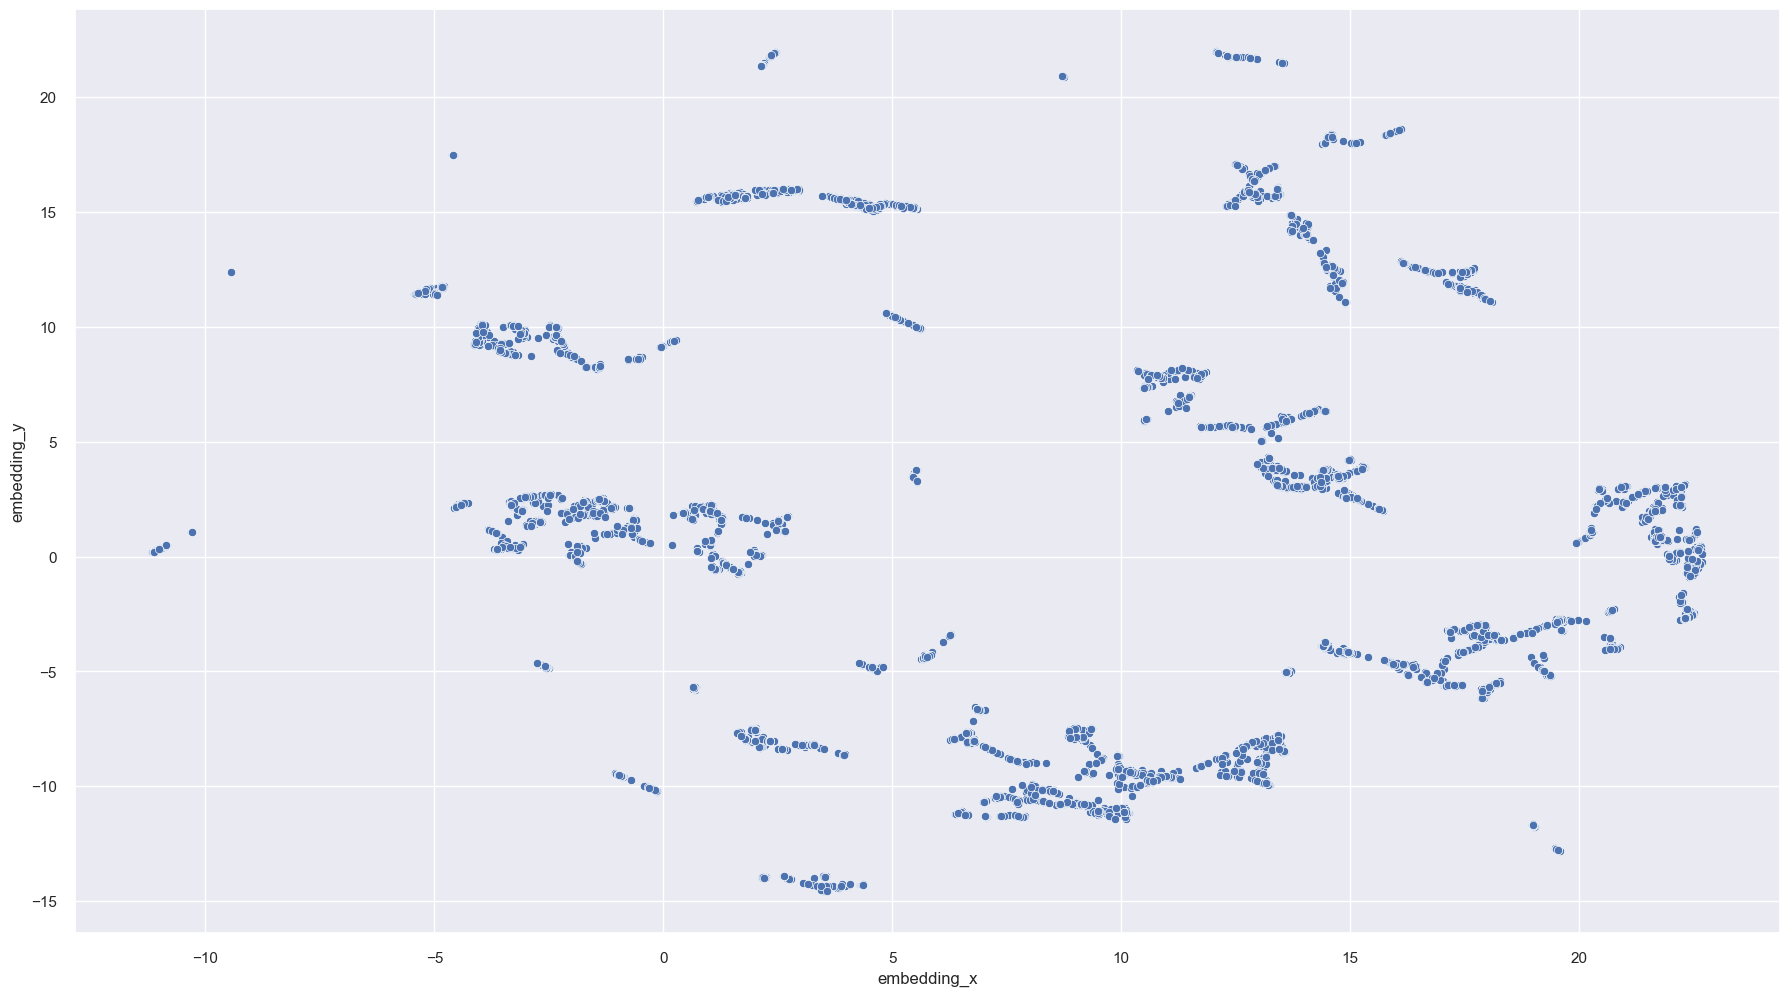

In [69]:
# Reducer dimensionality

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y',
                data=df_pca);

# <font color='black'> 5.0 Data Preparation </font>

In [132]:
df5 = df4.copy()

In [140]:
ss = pp.StandardScaler()

df5['gross_revenue'] = ss.fit_transform(df5[['gross_revenue']])
df5['recency_days'] = ss.fit_transform(df5[['recency_days']])
df5['invoice_no'] = ss.fit_transform(df5[['invoice_no']])
df5['avg_ticket'] = ss.fit_transform(df5[['avg_ticket']])

In [141]:
df5.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,0.378073,2.791512,3.893141,-0.033934
1,13047,0.135815,-0.361004,0.621632,-0.033422
2,12583,0.525560,-0.899726,1.406794,-0.026617
3,13748,-0.120552,0.028072,0.098191,-0.023239
4,15100,-0.128660,2.402435,-0.163530,0.152448


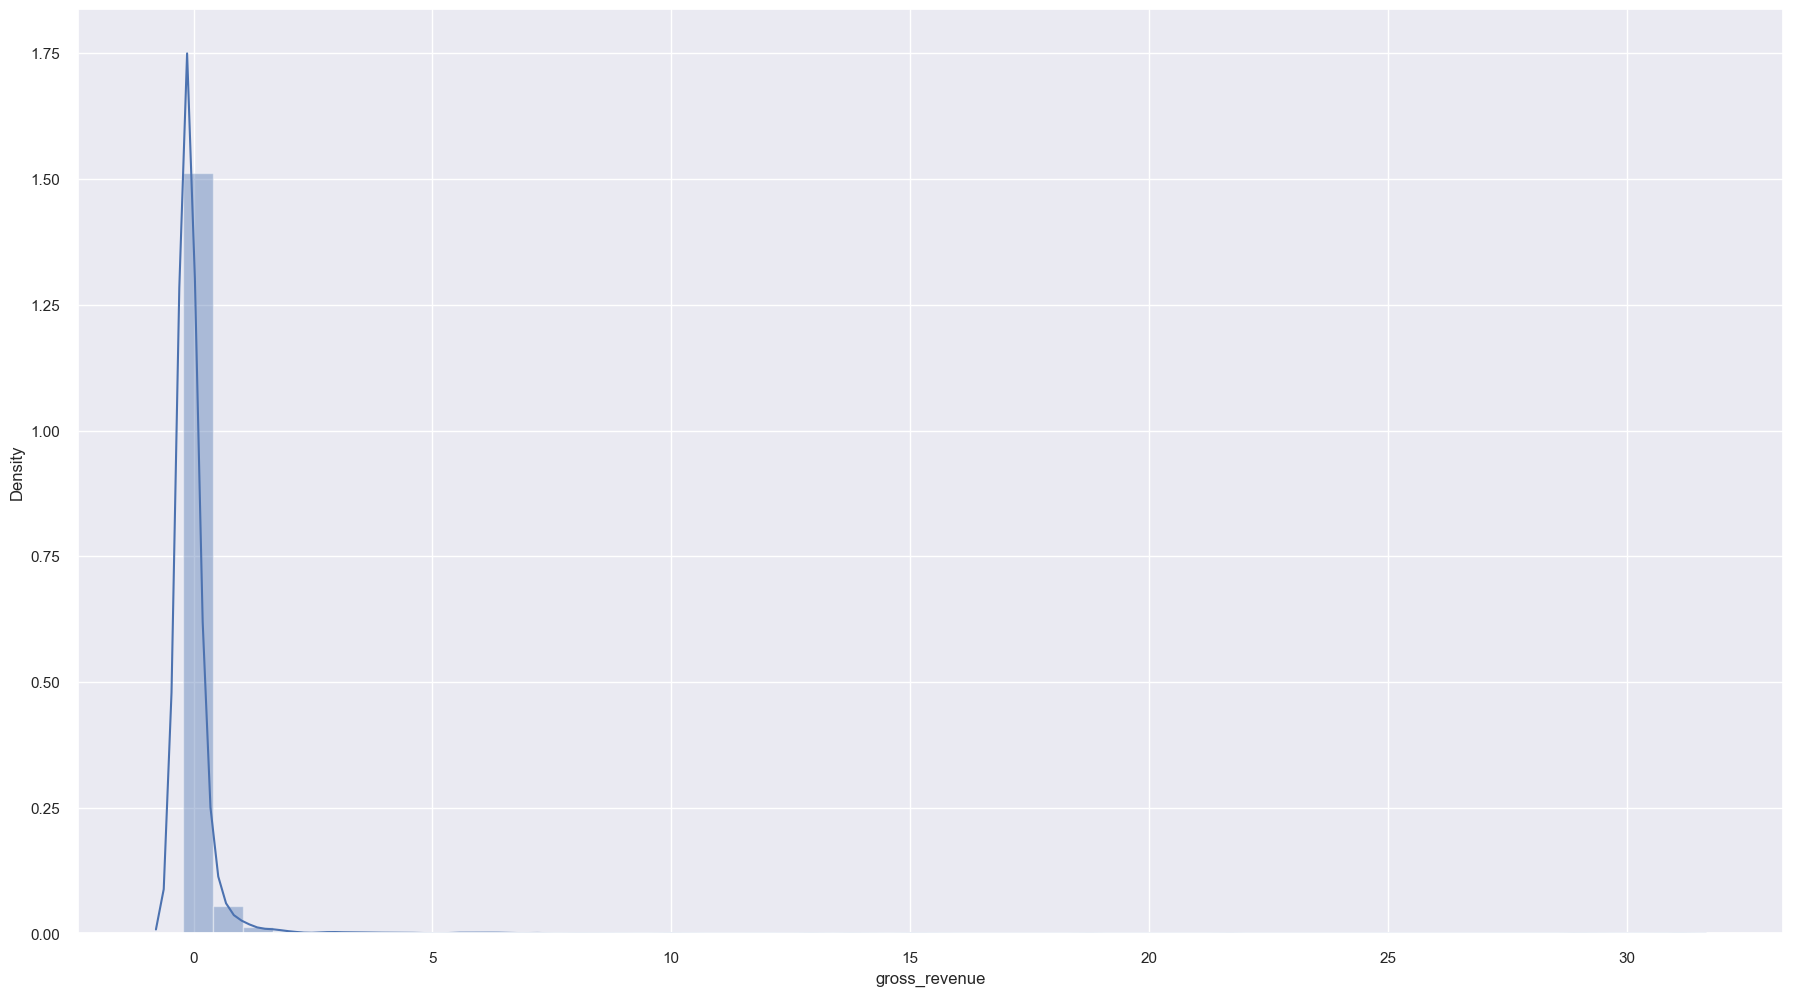

In [143]:
sns.distplot(df5['gross_revenue']);

# <font color='black'> 6.0 Feature Selection </font>

In [144]:
df6 = df5.copy()

# <font color='black'> 7.0 Hyperparameter Fine-Tunning </font>

In [145]:
# drop customer id
X = df6.drop(columns=['customer_id'])

In [146]:
X.head()

,gross_revenue,recency_days,invoice_no,avg_ticket
0,0.378073,2.791512,3.893141,-0.033934
1,0.135815,-0.361004,0.621632,-0.033422
2,0.525560,-0.899726,1.406794,-0.026617
3,-0.120552,0.028072,0.098191,-0.023239
4,-0.128660,2.402435,-0.163530,0.152448


In [147]:
clusters = [2,3,4,5,6,7]

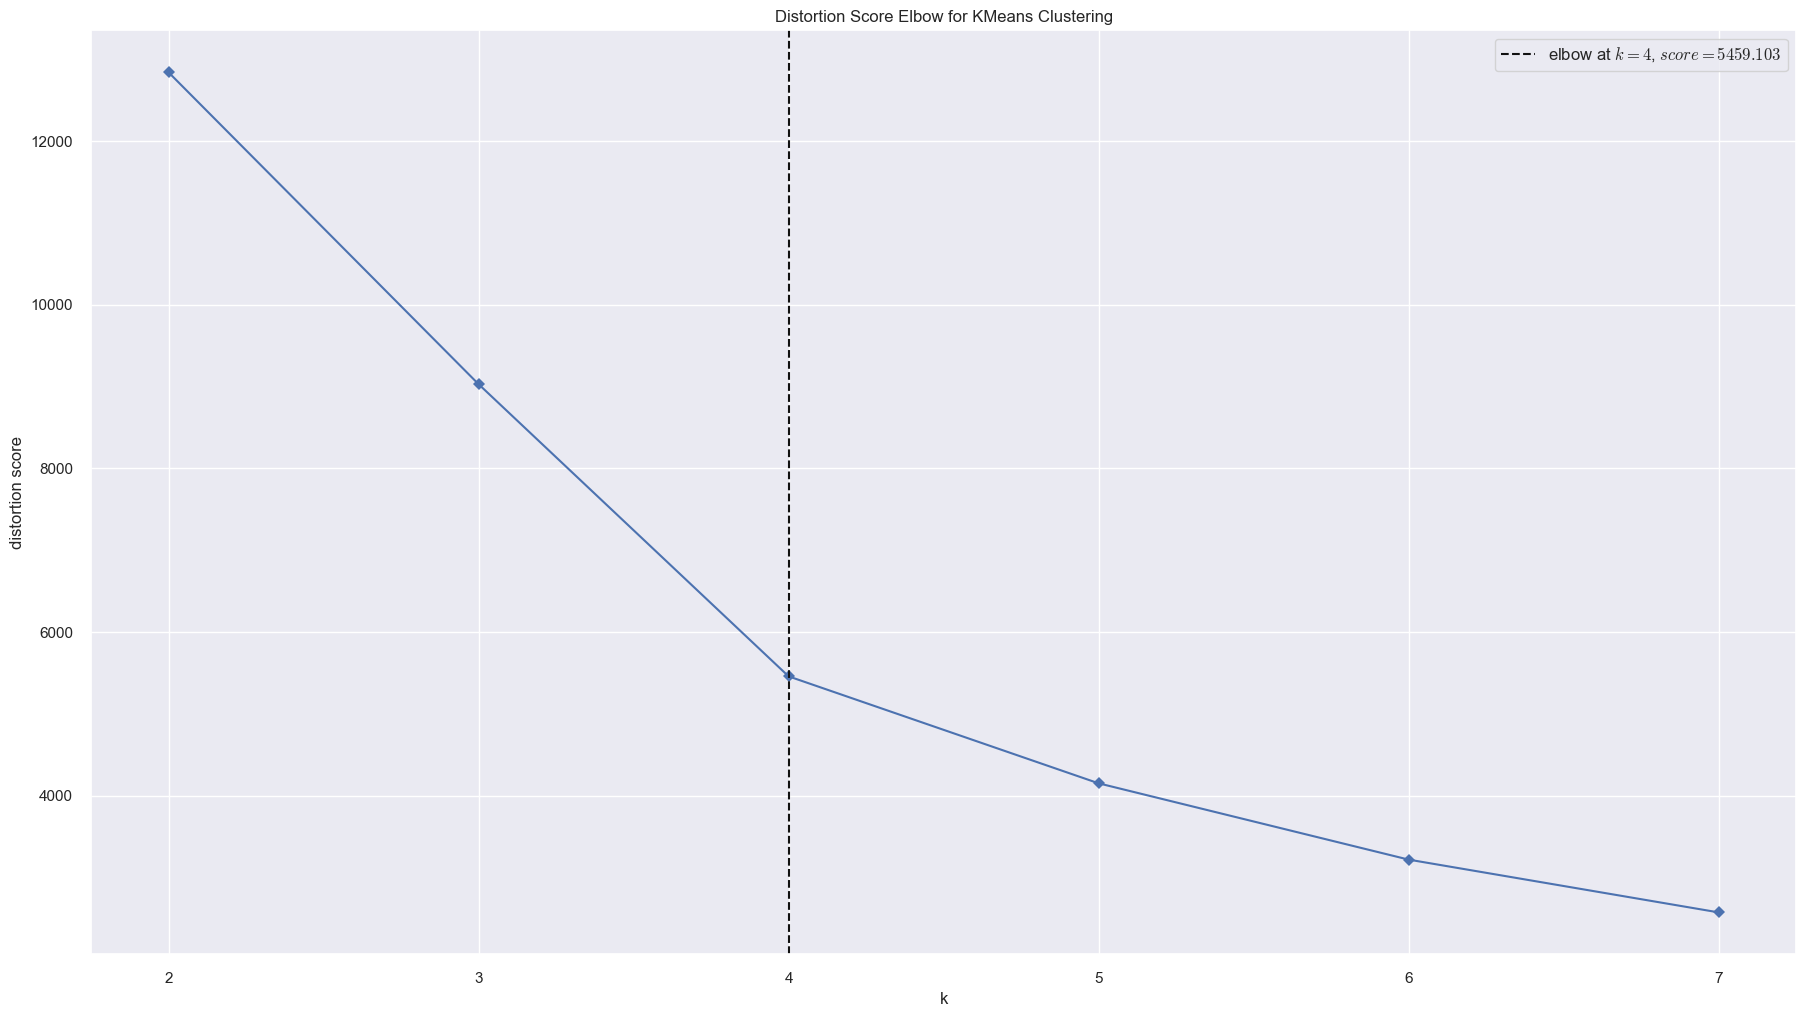

In [148]:
kmeans = KElbowVisualizer(c.KMeans(),k=clusters, timings=False)
kmeans.fit(X)
kmeans.show();

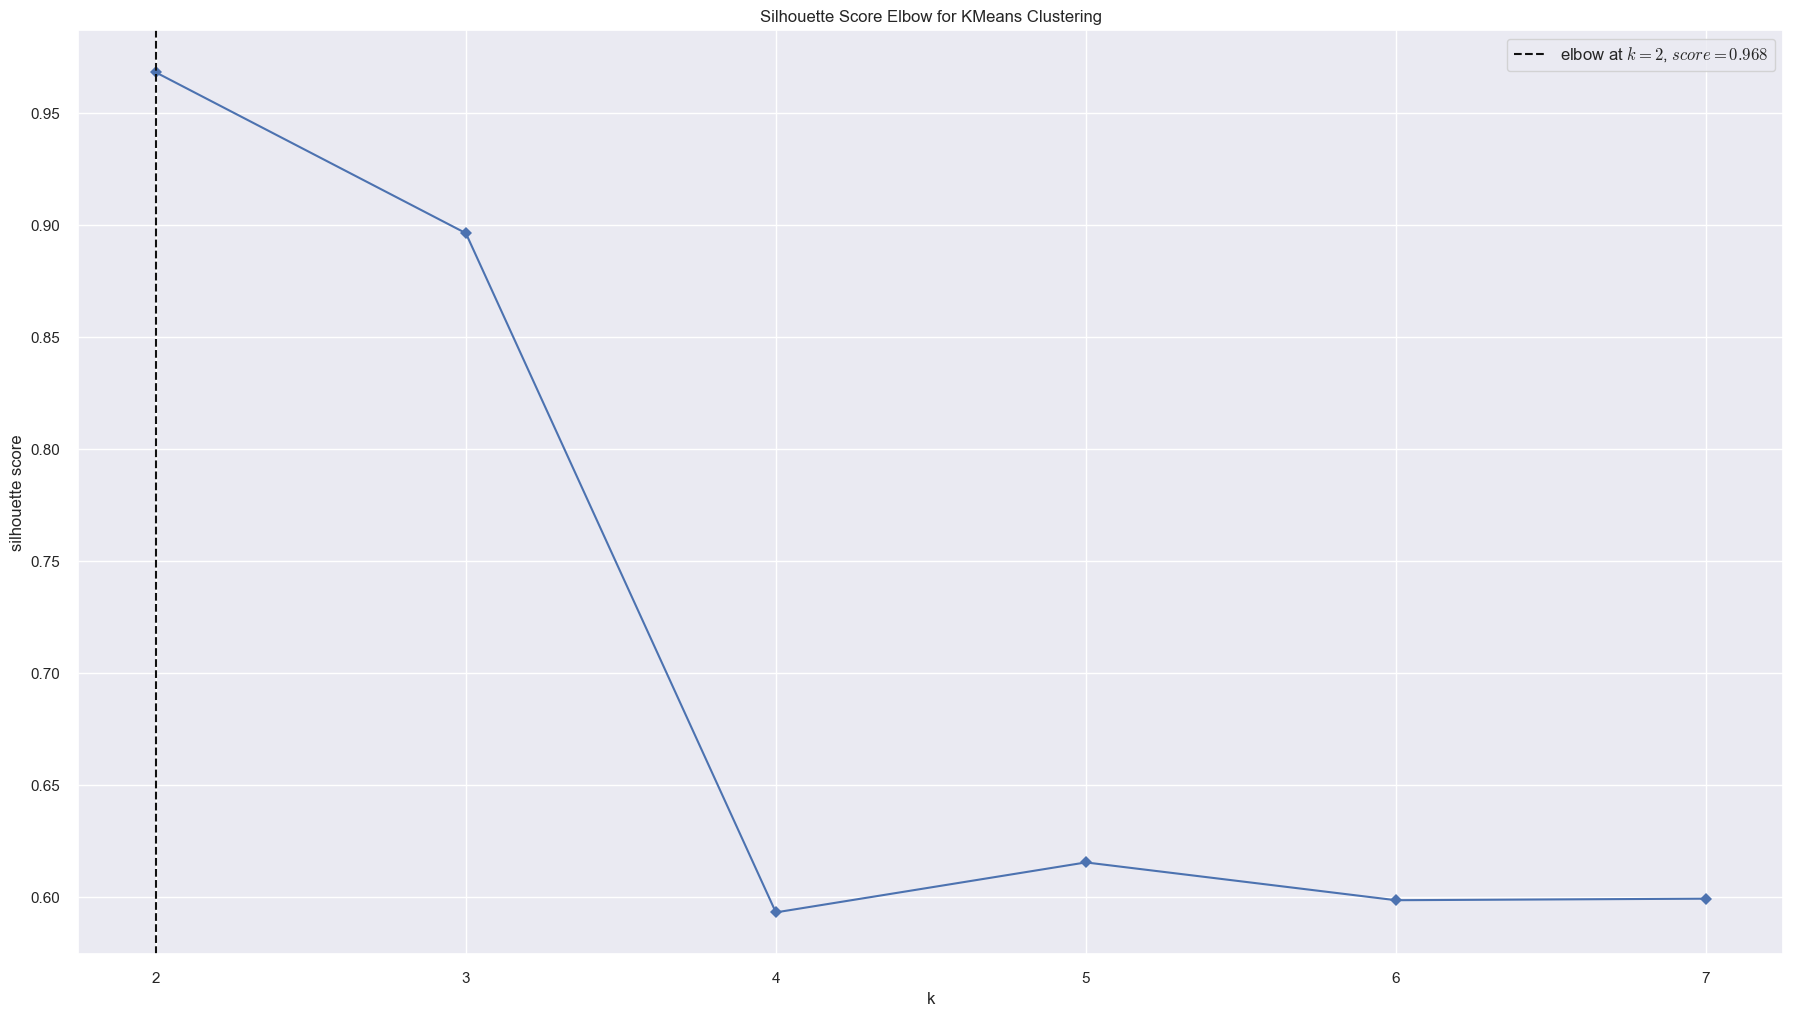

In [149]:
kmeans = KElbowVisualizer(c.KMeans(),k=clusters, metric='silhouette', timings=False)
kmeans.fit(X)
kmeans.show();

## <font color='black'> 7.1 Silhouette Analysis (SS)  </font>

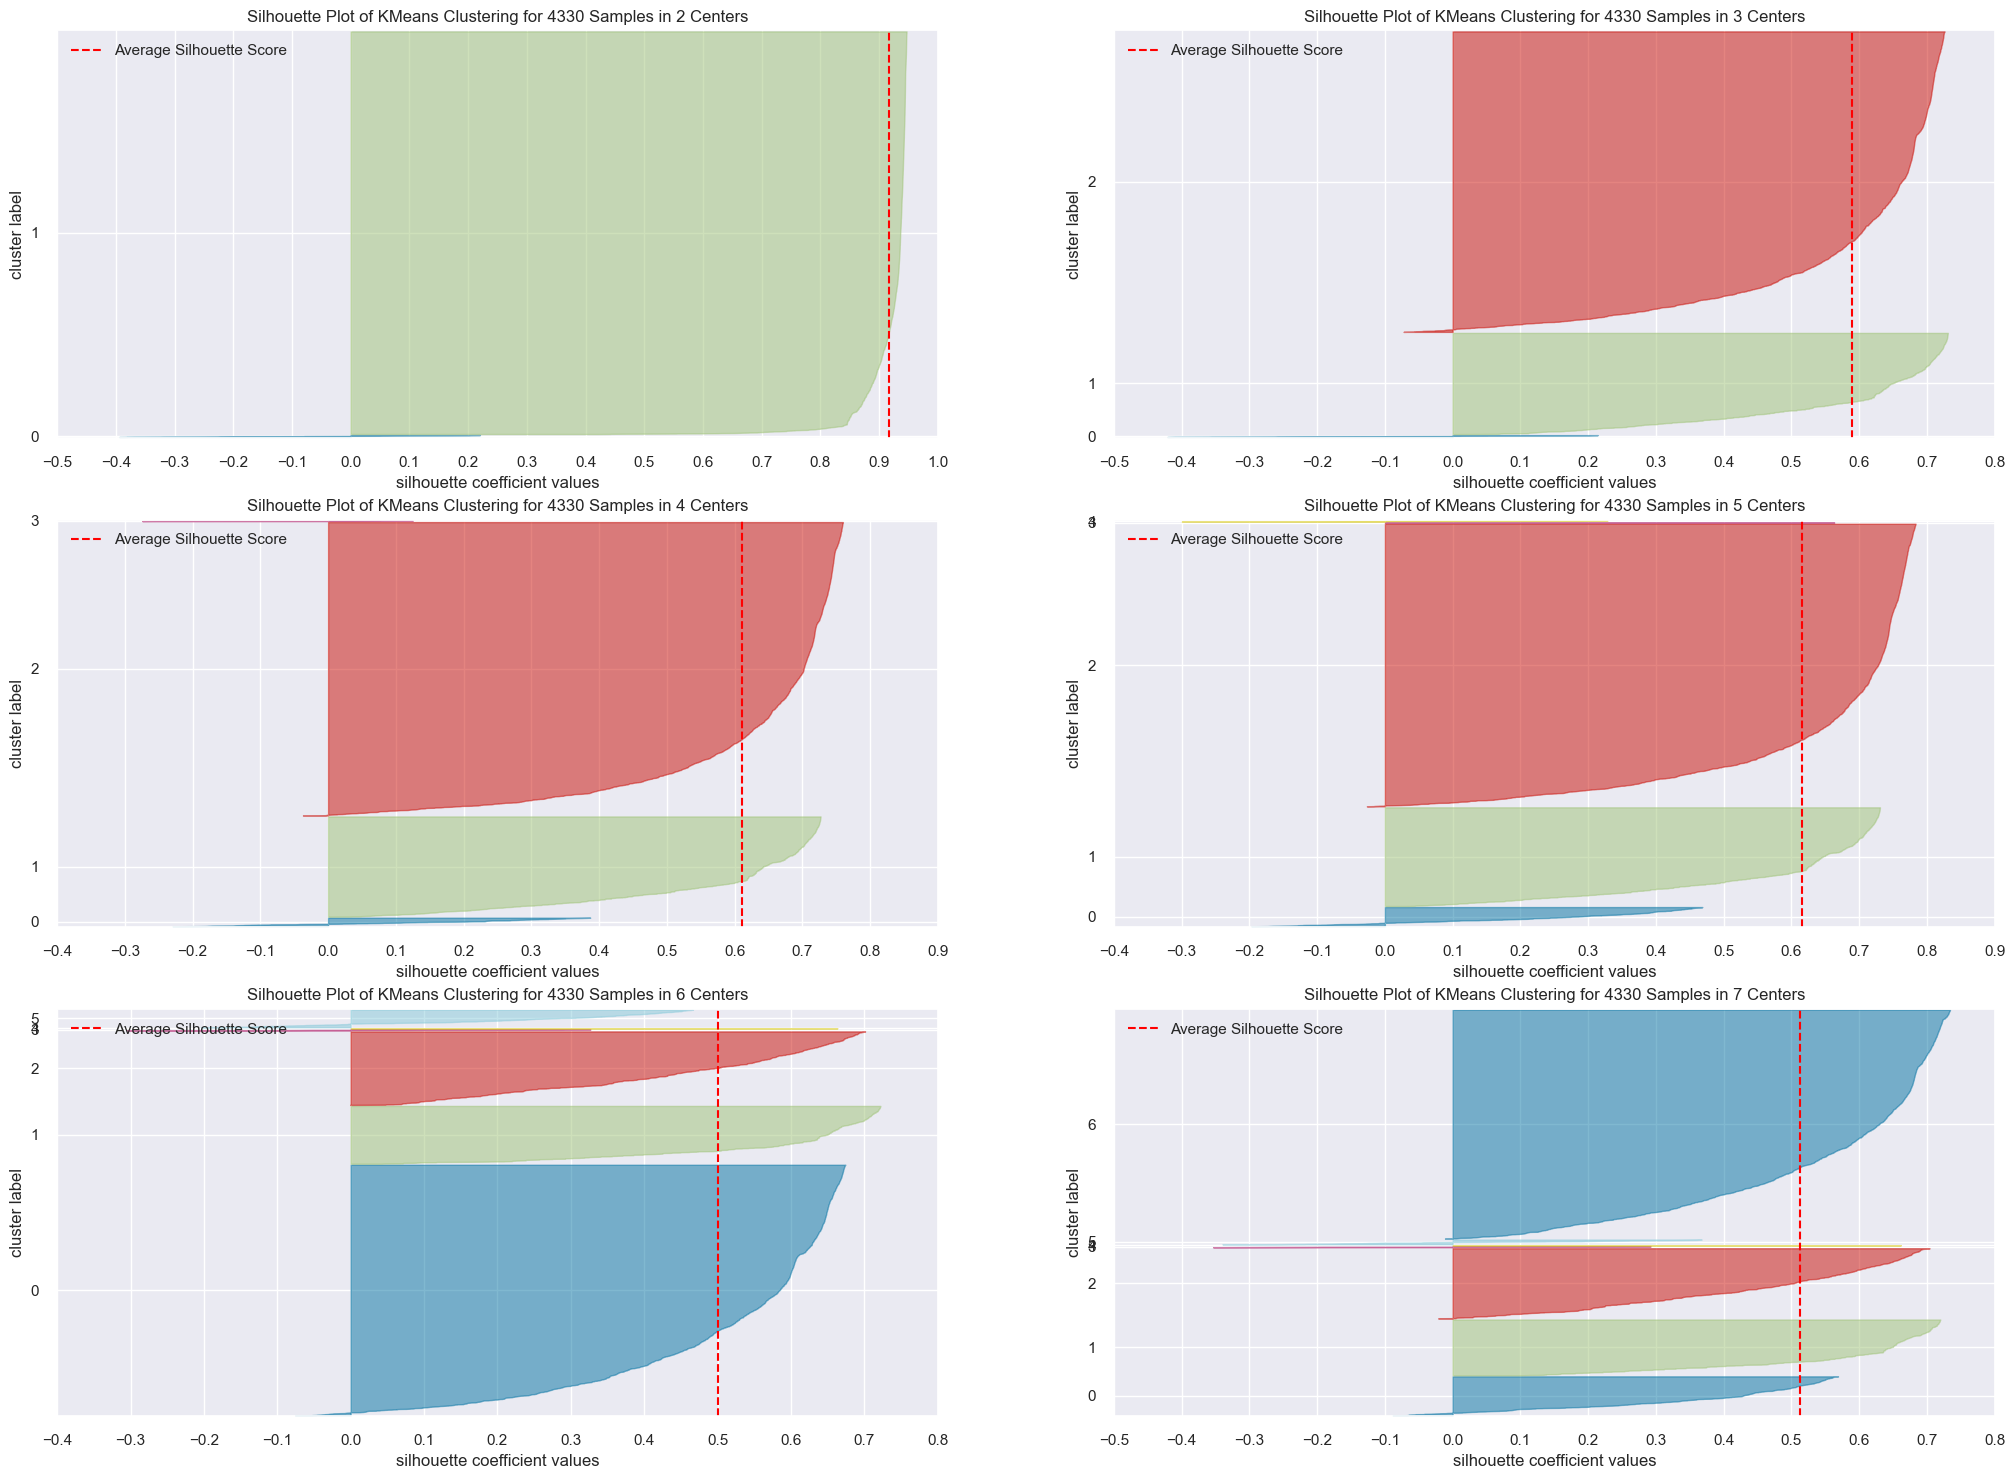

In [150]:
fig, ax = plt.subplots(3,2, figsize=(25,18))

for k in clusters:
    km=c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k,2)
    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

# <font color='black'> 8.0 Model Training </font>

## <font color='black'> 8.1 K-Means  </font>

In [151]:
# model definition
k=3
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X)

# clustering
labels= kmeans.labels_
labels

array([1, 2, 2, ..., 2, 2, 2])

## <font color='black'> 8.2 Cluster Validation  </font>

In [152]:
# WSS (Within-cluster Sum of square)
print('WSS value: {}'.format(kmeans.inertia_))

# SS (Silhouette Score)
print('SS value: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))


WSS value: 9408.2550506473
SS value: 0.5893633811956626


# <font color='black'> 9.0 Cluster Analysis </font>

In [153]:
df9=df6.copy()
df9['cluster'] = labels

In [154]:
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,0.378073,2.791512,3.893141,-0.033934,1
1,13047,0.135815,-0.361004,0.621632,-0.033422,2
2,12583,0.525560,-0.899726,1.406794,-0.026617,2
3,13748,-0.120552,0.028072,0.098191,-0.023239,2
4,15100,-0.128660,2.402435,-0.163530,0.152448,1


## <font color='black'> 9.1 Visualization Inspection  </font>

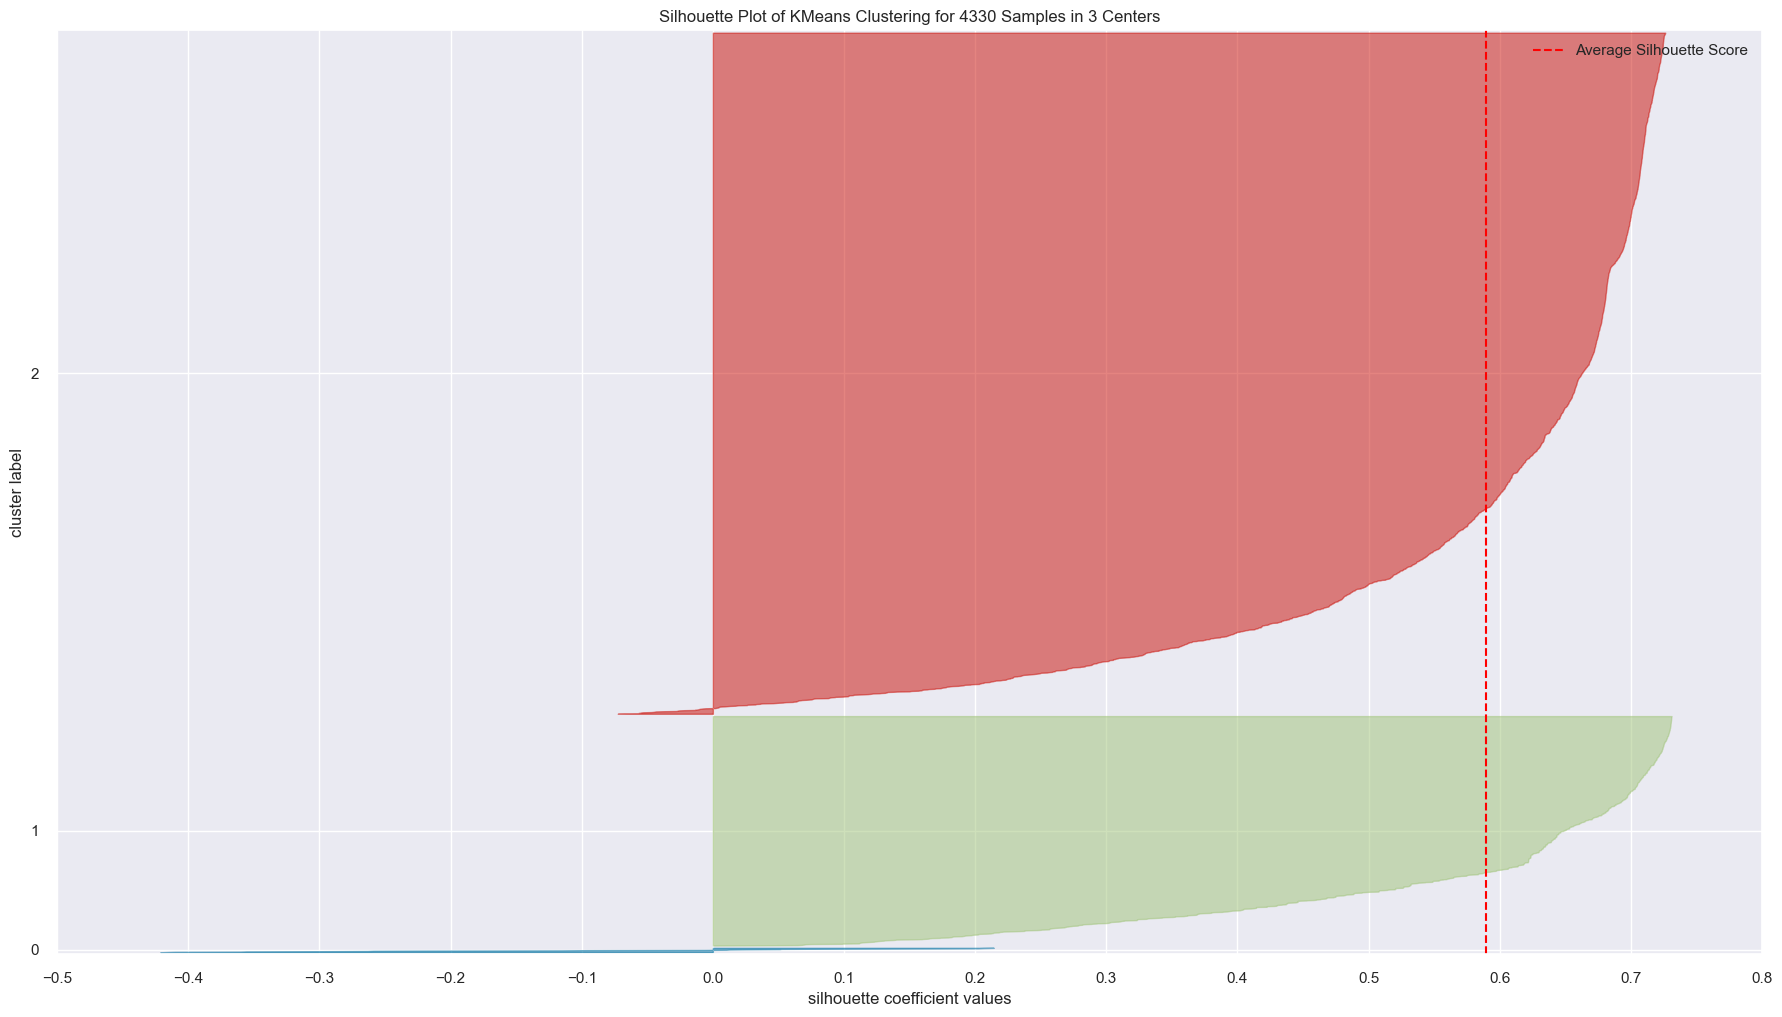

In [155]:
visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick')
visualizer.fit( X )
visualizer.finalize()

## <font color='black'> 9.2 2d Plot  </font>

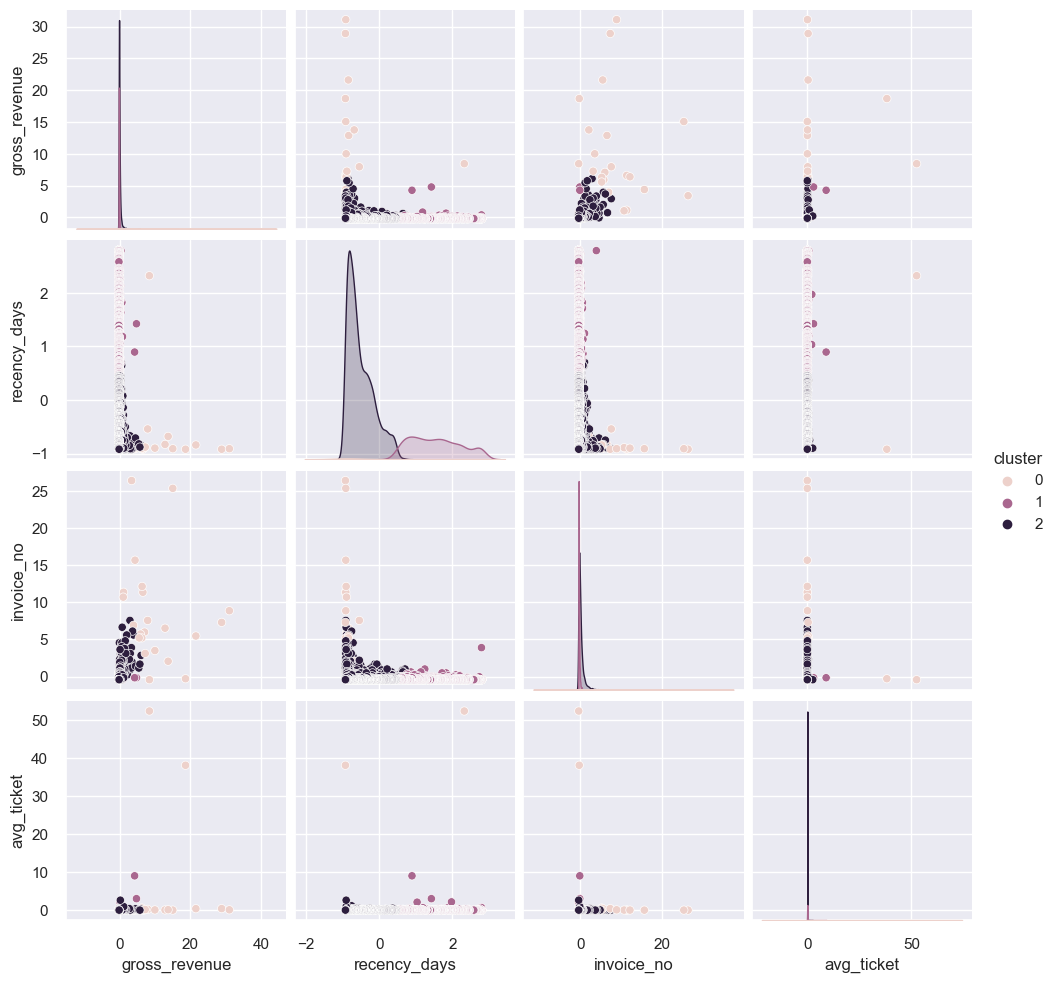

In [156]:
df_viz = df9.drop( columns='customer_id', axis=1)
sns.pairplot (df_viz,hue='cluster');

## <font color='black'> 9.3 UMAP  </font>


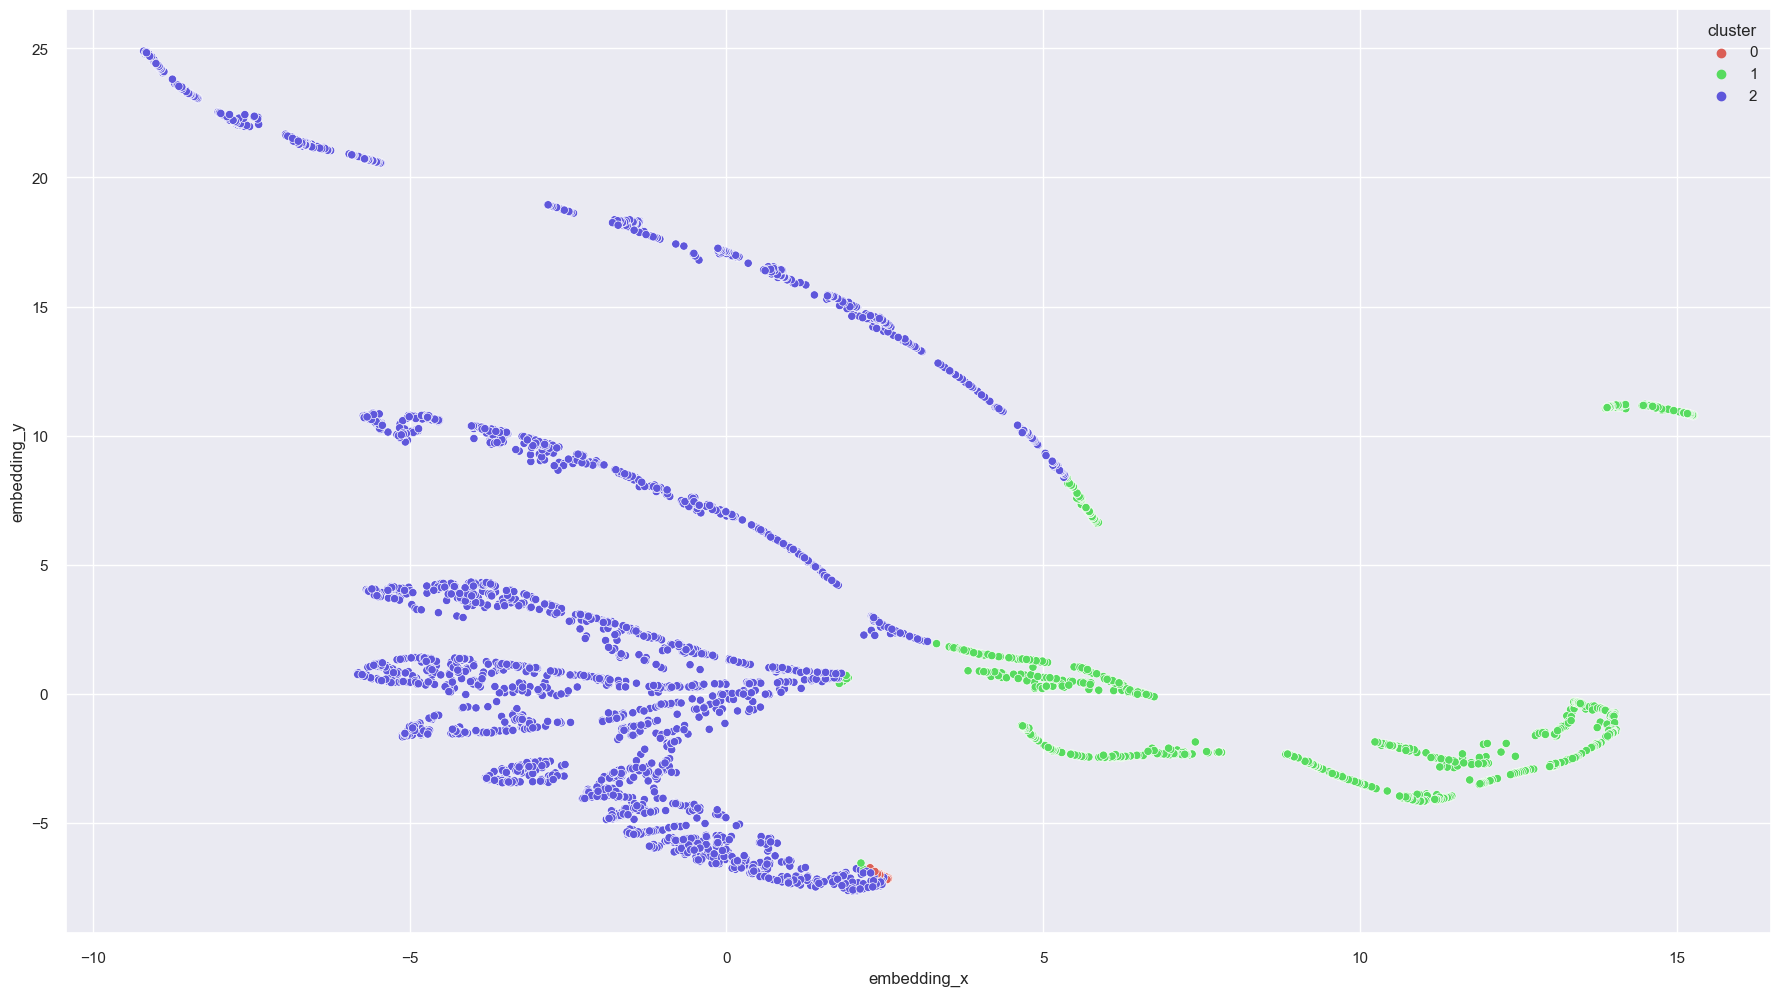

In [157]:
reducer = umap.UMAP(n_neighbors=40,random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y',
                hue='cluster',
                palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
                data=df_viz);

## <font color='black'> 9.2 Cluster Profile  </font>

In [125]:
# Number of customers
df_cluster = df9[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*df_cluster['customer_id']/df_cluster['customer_id'].sum()

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency days
df_avg_recency_days = df9[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Avg invoice_no
df_avg_invoice_no = df9[['invoice_no','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

# Avg ticket
df_ticket = df9[['avg_ticket','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, how='inner', on='cluster')


In [126]:
df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,16,0.369515,74627.483750,27.562500,51.500000,4988.363719
1,1,413,9.538106,5931.772785,26.193705,12.377724,60.568663
2,2,3859,89.122402,843.437621,100.342576,2.847111,28.488380
3,3,38,0.877598,25172.501053,17.789474,34.157895,585.433116
4,4,4,0.092379,225454.652500,2.250000,45.000000,14368.189768


# <font color='black'> 10.0 Deploy to Production </font>